In [3]:
from __future__ import division
import random

import pandas as pd
import numpy as np

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from collections import Counter
import os

home_dir = os.getcwd()


/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data preparation

In [4]:
def normalize_data(x):
    return (x - x.min(0)) / x.ptp(0)

In [5]:
def preprocess_data(data):
    data = data.replace("na", 0)
    data = data.replace("neg", 0)
    data = data.replace("pos", 1)

    return data

In [6]:
def oversampling(data, target):

    smote = SMOTE(ratio='minority')
    X_sm, y_sm = smote.fit_sample(data, target)

    print(sorted(Counter(y_sm).items()))

    return X_sm, y_sm

In [7]:
def undersampling(data, target):

    tl = TomekLinks(return_indices=True, ratio='majority')
    X_tl, y_tl, id_tl = tl.fit_sample(data, target)
    print(sorted(Counter(y_tl).items()))

    print('Removed indexes:', id_tl)

    return X_tl, y_tl,

In [8]:
def balance_dataset(data, target):
    smt = SMOTETomek(ratio='auto')
    X_smt, y_smt = smt.fit_sample(data, target)

    print(sorted(Counter(y_smt).items()))
    
    return X_smt, y_smt

In [9]:
def prepare():
    
    # our training and test datasets
    X_train = pd.read_csv(home_dir + '/scania/training_set_new.csv')
    X_test = pd.read_csv(home_dir + '/scania/test_set_new.csv') 

    dataset = pd.concat([X_train, X_test])
    dataset_y = dataset.iloc[:, 0]
    dataset_x = dataset.drop(dataset.columns[0], axis=1)
    
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    sns.countplot('class', data = X_train)
    plt.title('Training: Anomaly (1) vs. Normal (0)')
    plt.show()

    sns.countplot('class', data = dataset)
    plt.title('Dataset: Anomaly (1) vs. Normal (0)')
    plt.show()
    
    y_train = X_train.iloc[:, 0]  # First column in labels
    y_test = X_test.iloc[:, 0]  # First column in labels

    X_train = X_train.drop(X_train.columns[0], axis=1)  # delete first column of xtrain
    X_test = X_test.drop(X_test.columns[0], axis=1)  # delete first column of xtest    
    X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
    
    data = pd.DataFrame(np.column_stack((y_train_balanced, X_train_balanced)))
    data = data.rename(columns={0: 'class'})
    sns.countplot('class', data = data )
    plt.title('Oversampling: Anomaly (1) vs. Normal (0)')
    plt.show()
  
    return X_train_balanced, X_test, y_train_balanced, y_test, dataset_x, dataset_y

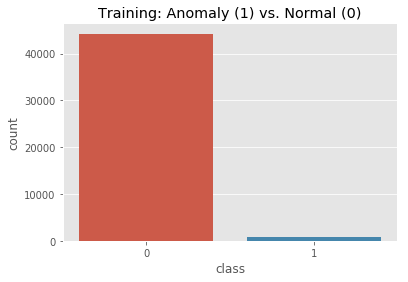

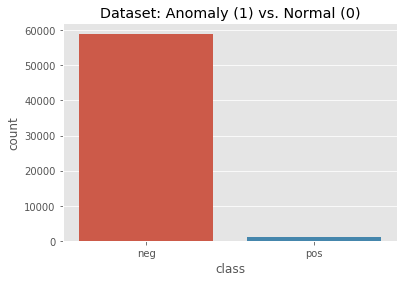

[(0, 44245), (1, 44245)]


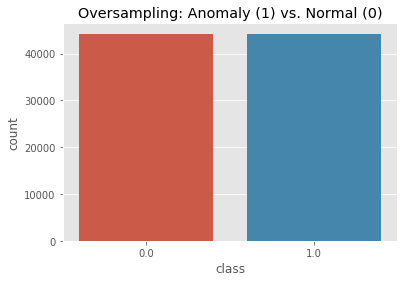

In [10]:
X_train, X_test, y_train, y_test, whole_dataset_x, whole_dataset_y = prepare()

# Cost Function

In [ ]:
def find_cost(y_test,predictions):
    normal_false = 0
    anomaly_false = 0
    normal_correct = 0
    anomaly_correct = 0
    for i in range(0, len(predictions)):
        if predictions[i] == 0 and y_test[i] == 1:  # He predicted normal but it was anomaly
            normal_false += 1
        elif predictions[i] == 1 and y_test[i] == 0:  # He predicted anomaly but it was normal
            anomaly_false += 1
        elif predictions[i] == 0 and y_test[i] == 0: # He predicted normal and it was normal
            normal_correct += 1
        elif predictions[i] == 1 and y_test[i] == 1: # He predicted anomaly and it was anomaly
            anomaly_correct += 1
            
    total_cost = 10*anomaly_false + 500*normal_false
    
    # print (("False anomaly predictions are {}".format(anomaly_false)))
    # print (("False normal predictions are {}".format(normal_false)))
    # print (("Correct normal predictions are {}".format(normal_correct)))
    # print (("Correct anomaly predictions are {}".format(anomaly_correct)))
    # print (("Total Cost is {}".format(total_cost)))
    
    return total_cost

    

# Feature Selection

In [ ]:
def feature_selection(X_train,y_train, num_of_features, X_test, y_test):
# Build RF classifier to use in feature selection
    knn = KNeighborsClassifier(n_neighbors=3)
    #create new scoring parameter based on cost function
    #cost_scorer = make_scorer(find_cost, greater_is_better= False)
    # Build step forward feature selection
    sfs1 = sfs(knn,
               k_features= num_of_features,
               forward=True,
               floating=False,
               verbose=2,
               scoring="f1",
               cv=5,
               n_jobs=-1)

    # Perform SFFS
    sfs1 = sfs1.fit(X_train, y_train)

    feat_cols = list(sfs1.k_feature_idx_)
    print(feat_cols)
    
    return feat_cols

## Execute model

In [ ]:
def execute_classifier(use_training, clf, X_train, X_test, y_train, y_test):

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    # predictions = np.round(predictions)

    if  use_training:
        prediction_prob = clf.predict_proba(X_test)
       
        predictions = []
        true_labels = []
        for pr in prediction_prob:
            if pr[0] > 0.95:
                predictions.append(0)  # Neg
            else:
                predictions.append(1)  # Pos

    accuracy = 0
    for i in range(0, len(predictions)):
        if predictions[i] == y_test[i]:
            accuracy +=1


    conf_mat = confusion_matrix(y_test, predictions)        
    average_precision = average_precision_score(y_test, predictions)

    #find average precision recall
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, predictions)

    #plot precision recall


    find_cost( y_test, predictions)
    print (("Total Cost is {}".format(total_cost)))

    return predictions, accuracy/len(predictions)

# KNN with all features

In [ ]:
knn = KNeighborsClassifier(3)

predictions, accuracy = execute_classifier(True, knn, X_train, X_test, y_train, y_test)
print("Accuracy of KNN with 170 features, is {} %".format(round((accuracy)*100, 5)))
print_metrics()

In [ ]:
# feat_cols = [9, 14, 21, 33, 37, 57, 94, 161, 162, 165] with imbalanced data
feat_cols = [0, 20, 71, 78, 89, 90, 100, 106, 142, 147]

#for i in feat_cols :
#feat_cols = feature_selection(X_train,y_train, 10, X_test, y_test)

x_train_less_feat = X_train[:, feat_cols]
x_test_less_feat = X_test.iloc[:,feat_cols]

x_train_less_feat.shape

In [ ]:
x_test_less_feat.shape


In [ ]:
print("Accuracy Score : ",accuracy_score(predictions,y_test))
print("F1 Score : ",f1_score(y_test, prediction, average=None))
print("Presicion Score :",precision_score(y_test, prediction, average=None))
print("ROC AUC Score :",roc_auc_score(y_test, prediction))
print("confusion matrix:", confusion_matrix(y_test, predictions))
print("Cross Validation Score :",cross_val_score(model, whole_dataset_x, whole_dataset_Y, cv=10, n_jobs=-1))  



## After the feature selection

In [ ]:
# predictions after feature selection
predictions_tocompare, accuracy_tocompare = execute_classifier(True, knn, x_train_less_feat, x_test_less_feat, y_train, y_test)
print("Accuracy of KNN with {} features, is {} %".format(len(feat_cols), round((accuracy_tocompare)*100, 5)))

In [ ]:
print("Accuracy Score : ",accuracy_score(predictions_tocompare,y_test))
print("F1 Score : ",f1_score(y_test, predictions_tocompare, average=None))
print("Presicion Score :",precision_score(y_test, predictions_tocompare, average=None))
print("ROC AUC Score :",roc_auc_score(y_test, predictions_tocompare))
print("confusion matrix:", confusion_matrix(y_test, predictions_tocompare))
print("Cross Validation Score :",cross_val_score(knn, whole_dataset_x, whole_dataset_Y, cv=10, n_jobs=-1))  



In [ ]:
n_neighbors = [3,5,11,19]
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan"]

hyperF = dict(n_neighbors = n_neighbors, weights = weights,metric = metric)

gridF = GridSearchCV(knn, hyperF, scoring="f1", cv=5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train_less_feat, y_train)

gridF.best_params_

In [ ]:
best_grid = gridF.best_estimator_
#predictions = best_grid.predict(x_test_less_feat)
# predictions = np.round(predictions)

prediction_prob = best_grid.predict_proba(x_test_less_feat)
       
predictions = []
true_labels = []
for pr in prediction_prob:
    if pr[0] > 0.95:
        predictions.append(0)  # Neg
    else:
        predictions.append(1)  # Pos

accuracy = 0
for i in range(0, len(predictions)):
    if predictions[i] == y_test[i]:
        accuracy +=1


average_precision = average_precision_score(y_test, predictions)


total_cost = find_cost(y_test, predictions)

####  Evaluation metrics after Grid Search

In [ ]:
print("Accuracy Score : ",accuracy_score(prediction,y_test))
print("Total Cost is : ", total_cost)
print("F1 Score : ",f1_score(y_test, prediction, average=None))
print("Presicion Score :",precision_score(y_test, prediction, average=None))
print("ROC AUC Score :",roc_auc_score(y_test, prediction))
print("confusion matrix:", confusion_matrix(y_test, predictions))
print("Cross Validation Score :",cross_val_score(model, whole_dataset_x, whole_dataset_Y, cv=10, n_jobs=-1))  

